## **0. Download dataset**
**Note:** If you can't download using gdown due to limited number of downloads, please download it manually and upload it to your drive, then copy it from the drive to colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

## **1. Import libraries**

In [1]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

## **2. Read dataset**

In [3]:
root_dir = '/kaggle/input/densenet-scenes/scenes_classification'
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'val')

classes = {
    label_idx: class_name \
        for label_idx, class_name in enumerate(
            sorted(os.listdir(train_dir))
        )
}

X_train = []
y_train = []
X_test = []
y_test = []
for dataset_path in [train_dir, test_dir]:
    for label_idx, class_name in classes.items():
        class_dir = os.path.join(dataset_path, class_name)
        for img_filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_filename)
            if 'train' in dataset_path:
                X_train.append(img_path)
                y_train.append(label_idx)
            else:
                X_test.append(img_path)
                y_test.append(label_idx)

In [4]:
classes

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

## **3. Train, val, test split**

In [5]:
val_size = 0.2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

## **4. Create pytorch dataset**

In [6]:
class ScenesDataset(Dataset):
    def __init__(
        self,
        x, y,
        transform=None
    ):
        self.images_path = x
        self.labels = y
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.images_path[idx]
        labels = self.labels[idx]

        img = Image.open(img_path).convert('RGB')
        if self.transform != None:
            img = self.transform(img)
        return img, labels

## **5. Create data preprocessing function**

resize ảnh, đổi về tensor, chuyển dim và chuẩn hóa giá trị pixel về khoảng (0, 1).

In [7]:
def transform(img : Image.Image, img_size=(224, 224)):
    img = img.resize(img_size)
    img = np.array(img)
    # W-H-C --> C-H-W
    img = torch.Tensor(img).permute(2, 0, 1).float()
    img = img / 255.0
    return img

## **6. Create dataloader**

In [8]:
train_dataset = ScenesDataset(
    X_train, y_train,
    transform=transform
)
val_dataset = ScenesDataset(
    X_val, y_val,
    transform=transform
)
test_dataset = ScenesDataset(
    X_test, y_test,
    transform=transform
)

In [9]:
train_batch_size = 64
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


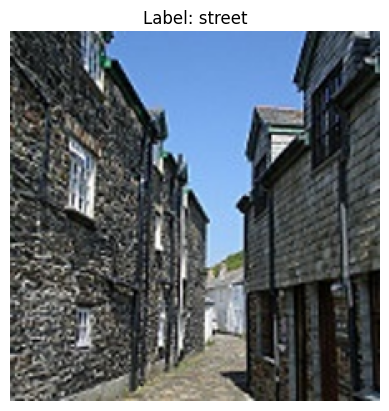

In [10]:
train_features, train_labels = next(iter(train_loader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[0].permute(1, 2, 0)
label = train_labels[0].item()
plt.imshow(img)
plt.axis('off')
plt.title(f'Label: {classes[label]}')
plt.show()

## **7. Create model**

In [11]:
class BottleneckBlock(nn.Module):
    '''
        lưu ý là res và x phải có cùng shape , vậy nên khi set ConV phải thêm padding để đảm bảo điều này 
    '''

    def __init__(self, in_channels, growth_rate = 32):
        super(BottleneckBlock, self).__init__()
        self.norm1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=growth_rate * 4, kernel_size=1, bias=False)
        self.norm2 = nn.BatchNorm2d(growth_rate * 4)
        self.conv2 = nn.Conv2d(in_channels=growth_rate * 4, out_channels=growth_rate, kernel_size=3, padding=1, bias=False)
        self.relu = nn.ReLU()
    def forward(self, x):
        # res có dim = inchannels
        res = x.clone()
        # print("shape res: ", res.shape)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.conv1(x)

        x = self.norm2(x)
        x = self.relu(x)
        x = self.conv2(x)
        # print("shape x: ", x.shape)
        #  x_dims = x_res + x_dims
        x = torch.cat([res, x], 1)
        return x

class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate = 32):
        super(DenseBlock, self).__init__()
        self.block = nn.Sequential()
        for i in range(num_layers):
            self.block.append(BottleneckBlock(in_channels=in_channels + i * growth_rate, growth_rate=growth_rate))
        

    def forward(self, x):
        return self.block(x)
    
class transition_layer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(transition_layer, self).__init__()
        self.norm1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, bias=False)
        self.avg_pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.norm1(x)
        x = self.conv1(x)
        x = self.avg_pool1(x)
        return x
    
class classification_layer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(classification_layer, self).__init__()

        self.in_channels = in_channels
        self.norm1 = nn.BatchNorm2d(in_channels)
        
        # output: 7x7 -> 1x1
        self.pool1 = nn.AvgPool2d(kernel_size=7)
        self.relu = nn.ReLU()
        self.output = nn.Linear(in_channels, out_channels)

    def forward(self, x):
        # print("in channels classification", self.in_channels)
        # print("classification:", x.shape)
        x = self.norm1(x)
        x = self.pool1(x)
        x = self.relu(x)

        x = x.view(x.size(0), -1)
        x = self.output(x)

        return x

In [12]:
class DenseNet(nn.Module):
    def __init__(self, num_blocks, growth_rate, num_classes):
        super(DenseNet, self).__init__()
        # điều chỉnh padding để sau khi conv output = 112 * 112
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.norm1 = nn.BatchNorm2d(64)
        # 112 * 112 -> 56 * 56
        self.pooling = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.denseblocks = nn.ModuleList()
        in_channels = 64
        for i, num in enumerate(num_blocks):
            self.denseblocks.append(DenseBlock(num, in_channels, growth_rate))

            in_channels += (growth_rate * num)
            if i != len(num_blocks) - 1:
                # mục đích của transition layer là giảm số dim tránh concat làm stack quá nhiều
                out_channels = in_channels // 2
                self.denseblocks.append(transition_layer(in_channels, out_channels))
            
            # out_channels layer trước là in_channels layer sau
            in_channels = out_channels

        self.classification_layer = classification_layer(
            # lần cuối in_channels = outchannel nhưng do kh xài transition layer ở lần cuối nên cần *2 lại
            in_channels * 2, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.pooling(x)

        for block in self.denseblocks:
            x = block(x)

        x = self.classification_layer(x)
        return x

In [13]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = DenseNet(
    [6, 12, 24, 16],
    growth_rate=32,
    num_classes=n_classes
).to(device)

In [14]:
model.eval()

dummy_tensor = torch.randn(1, 3, 224, 224).to(device)

with torch.no_grad():
    output = model(dummy_tensor)

print('Output shape:', output.shape)

Output shape: torch.Size([1, 6])


## **8. Training**

In [15]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [16]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

    return train_losses, val_losses

In [17]:
lr = 1e-3
epochs = 100

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr
)

In [18]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

EPOCH 1:	Train loss: 1.4490	Val loss: 1.2402
EPOCH 2:	Train loss: 1.1496	Val loss: 1.0519
EPOCH 3:	Train loss: 0.9784	Val loss: 0.9097
EPOCH 4:	Train loss: 0.8429	Val loss: 0.8166
EPOCH 5:	Train loss: 0.7474	Val loss: 0.7948
EPOCH 6:	Train loss: 0.6733	Val loss: 0.6720
EPOCH 7:	Train loss: 0.6263	Val loss: 0.8749
EPOCH 8:	Train loss: 0.5818	Val loss: 0.9332
EPOCH 9:	Train loss: 0.5523	Val loss: 0.5901
EPOCH 10:	Train loss: 0.5250	Val loss: 0.6144
EPOCH 11:	Train loss: 0.5035	Val loss: 0.7165
EPOCH 12:	Train loss: 0.4809	Val loss: 0.8148
EPOCH 13:	Train loss: 0.4611	Val loss: 0.7300
EPOCH 14:	Train loss: 0.4390	Val loss: 0.6672
EPOCH 15:	Train loss: 0.4177	Val loss: 0.8371
EPOCH 16:	Train loss: 0.4068	Val loss: 0.5905
EPOCH 17:	Train loss: 0.3922	Val loss: 0.5420
EPOCH 18:	Train loss: 0.3832	Val loss: 0.5482
EPOCH 19:	Train loss: 0.3605	Val loss: 0.4670
EPOCH 20:	Train loss: 0.3562	Val loss: 0.5957
EPOCH 21:	Train loss: 0.3412	Val loss: 0.8239
EPOCH 22:	Train loss: 0.3275	Val loss: 0.94

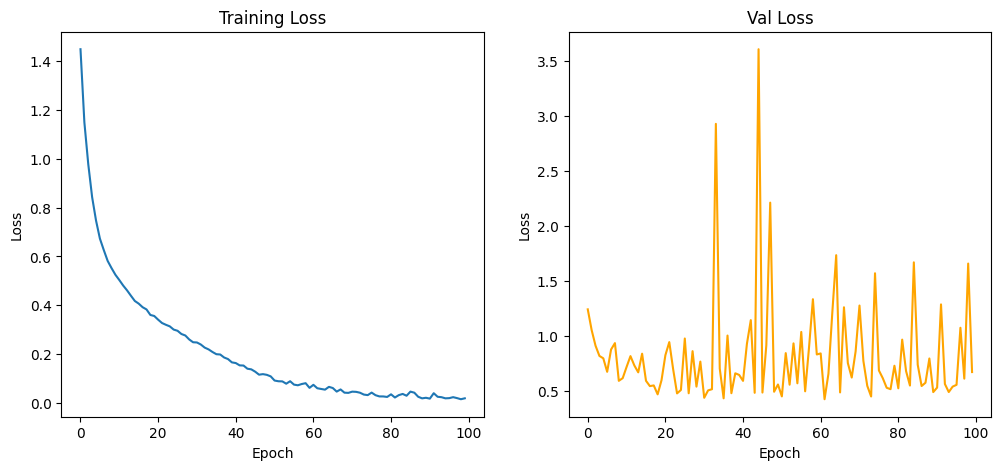

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

## **9. Evaluation**

In [20]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.827930174563591
Test accuracy:  0.829
